In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import glob
import torchvision.transforms as transforms

In [2]:
batch_size = 16
n_epochs = 100

In [3]:
train_path = '/tmp2/b08902134/testdata/hw1_data/p2_data/train/'
valid_path = '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/'
chkpt_dir = '/tmp2/b08902134/hw1_checkpoint/'

In [4]:
def mask_target(path):
    mask = Image.open(path).convert('RGB')
    mask = np.array(mask).astype(np.uint8)
    mask = (mask >= 128).astype(int)
    mask = 4 * mask[:, :, 0] + 2 * mask[:, :, 1] + mask[:, :, 2]
    masks = np.zeros((512,512))
    masks[mask == 3] = 0  # (Cyan: 011) Urban land 
    masks[mask == 6] = 1  # (Yellow: 110) Agriculture land 
    masks[mask == 5] = 2  # (Purple: 101) Rangeland 
    masks[mask == 2] = 3  # (Green: 010) Forest land 
    masks[mask == 1] = 4  # (Blue: 001) Water 
    masks[mask == 7] = 5  # (White: 111) Barren land 
    masks[mask == 0] = 6  # (Black: 000) Unknown
    masks[mask == 4] = 6  # (Red: 100) Unknown
    
    return torch.LongTensor(masks)

In [4]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

In [6]:
class TrainSet(Dataset):
    def __init__(self, path, transform = None, phase = 'train'):
        self.images = None
        self.labels = None
        self.length = 2000 if phase == 'train' else 257
        self.filenames = [("{}{:04}_sat.jpg".format(path,i), "{}{:04}_mask.png".format(path,i)) for i in range(self.length)]
        self.transform = transform
                              
    def __getitem__(self, idx):
        sat_name, mask_name= self.filenames[idx]
        sat = Image.open(sat_name).convert('RGB')
        if self.transform is not None:
            sat = self.transform(sat)

        return sat, mask_target(mask_name)

    def __len__(self):
        return self.length

In [11]:
class VGG16_FCN32(nn.Module):
    def __init__(self, n_class = 7):
        super(VGG16_FCN32, self).__init__()
        self.name = 'vgg16_fcn32'
        self.vgg = models.vgg16(pretrained = True).features
        self.fcn = nn.Sequential(
                nn.Conv2d(512, 4096, 1),
                nn.ReLU(inplace=True),
                nn.Dropout2d(),
                nn.Conv2d(4096, 4096, 1),
                nn.ReLU(inplace=True),
                nn.Dropout2d()
            )
        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.upscore = nn.ConvTranspose2d(n_class, n_class, 64, stride=32, bias = False)
        
        # self._initialize_weights()
        
    def forward(self, x):
        shape = x.shape
        x = self.vgg(x)
        x = self.fcn(x)
        x = self.score_fr(x)
        x = self.upscore(x)
        x = x[:, :, 16: 16 + shape[2], 16: 16 + shape[3]]
        return x
    

In [12]:
class WarmupPolyLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, target_lr=0, max_iters=0, power=0.9, warmup_factor=1.0 / 3,
                 warmup_iters=500, warmup_method='linear', last_epoch=-1):
        if warmup_method not in ("constant", "linear"):
            raise ValueError(
                "Only 'constant' or 'linear' warmup_method accepted "
                "got {}".format(warmup_method))

        self.target_lr = target_lr
        self.max_iters = max_iters
        self.power = power
        self.warmup_factor = warmup_factor
        self.warmup_iters = warmup_iters
        self.warmup_method = warmup_method

        super(WarmupPolyLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        N = self.max_iters - self.warmup_iters
        T = self.last_epoch - self.warmup_iters
        if self.last_epoch < self.warmup_iters:
            if self.warmup_method == 'constant':
                warmup_factor = self.warmup_factor
            elif self.warmup_method == 'linear':
                alpha = float(self.last_epoch) / self.warmup_iters
                warmup_factor = self.warmup_factor * (1 - alpha) + alpha
            else:
                raise ValueError("Unknown warmup type.")
            return [self.target_lr + (base_lr - self.target_lr) * warmup_factor for base_lr in self.base_lrs]
        factor = pow(1 - T / N, self.power)
        return [self.target_lr + (base_lr - self.target_lr) * factor for base_lr in self.base_lrs]

In [17]:
train_set = TrainSet(train_path, transform)
valid_set = TrainSet(valid_path, transform, phase = 'dev')
device = 'cuda:0'
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size= batch_size, shuffle = False, num_workers=8, pin_memory=True)

In [18]:
model = VGG16_FCN32().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4, momentum = 0.9, weight_decay = 2e-4)
scheduler = WarmupPolyLR(optimizer, power=0.9)

In [15]:
def mean_iou_score(pred, labels):
    mean_iou = 0
    for i in range(6):
        tp_fp = np.sum(pred == i)
        tp_fn = np.sum(labels == i)
        tp = np.sum((pred == i) * (labels == i))
        iou = tp / (tp_fp + tp_fn - tp)
        mean_iou += iou / 6

    return mean_iou

In [ ]:
best_acc = 0.0
result = []
from tqdm import tqdm
for epoch in range(n_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch + 1, n_epochs))
    
    model.train()
    train_loss = []
    train_accs = []
    for batch in tqdm(train_loader):
        imgs, target = batch
        imgs, target = imgs.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        train_loss.append(loss.item())
    train_loss = sum(train_loss) / len(train_loss)

    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}")

    model.eval()
    valid_loss = []
    valid_accs = []
    labels, prediction = [], []
    mean_iou = 0
    tp_fp = torch.zeros(6, device=device)
    tp_fn = torch.zeros(6, device=device)
    tp = torch.zeros(6, device=device)
    with torch.no_grad():
        for imgs, target in valid_loader:
            imgs, target = imgs.to(device), target.to(device)
            output = model(imgs)
            loss = criterion(output, target)
            valid_loss.append(loss.item())
            pred = output.max(1, keepdim=True)[1].view_as(target)
            for i in range(6):
                tp_fp[i] += torch.sum(pred == i)
                tp_fn[i] += torch.sum(target == i)
                tp[i] += torch.sum((pred == i) * (target == i))

    val_loss = sum(valid_loss) / len(valid_loss)

    for i in range(6):
        iou = tp[i] / (tp_fp[i] + tp_fn[i] - tp[i])
        mean_iou += iou / 6

    valid_loss = sum(valid_loss) / len(valid_loss)
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f} mean_iou = {mean_iou:.5f}")
    result.append((epoch + 1, valid_loss, mean_iou))
    torch.save(model.state_dict(), f'{chkpt_dir}{model.name}_{epoch + 1}.ckpt', _use_new_zipfile_serialization = False)

----------
Epoch 1/100


100%|█████████████████████████████████████████████████████████████| 125/125 [01:34<00:00,  1.32it/s]

[ Train | 001/100 ] loss = 1.94590


[ Valid | 001/100 ] loss = 1.94590 mean_iou = 0.06520
----------
Epoch 2/100


100%|█████████████████████████████████████████████████████████████| 125/125 [01:12<00:00,  1.72it/s]

[ Train | 002/100 ] loss = 1.94590


[ Valid | 002/100 ] loss = 1.94590 mean_iou = 0.06523
----------
Epoch 3/100


 14%|████████▍                                                     | 17/125 [00:13<00:49,  2.20it/s]

In [9]:
import os

In [19]:
class TestSet(Dataset):
    def __init__(self, path, transform = None):
        self.filenames = sorted(glob.glob(os.path.join(path, '*.jpg')))
        print(self.filenames)
        self.transform = transform
                              
    def __getitem__(self, idx):
        sat_name = self.filenames[idx]
        sat = Image.open(sat_name).convert('RGB')
        if self.transform is not None:
            sat = self.transform(sat)
        return sat, sat_name.split('/')[-1].split('_')[0]

    def __len__(self):
        return len(self.filenames)

In [20]:
device = torch.device('cuda')

In [21]:
class FCN32s(nn.Module):
    def __init__(self, n_class = 7):
        super(FCN32s, self).__init__()
        self.name = 'vgg16_fcn32'
        self.vgg = models.vgg16(pretrained = True).features
        self.fcn = nn.Sequential(
                nn.Conv2d(512, 4096, 1),
                nn.ReLU(inplace=True),
                nn.Dropout2d(),
                nn.Conv2d(4096, 4096, 1),
                nn.ReLU(inplace=True),
                nn.Dropout2d()
            )
        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.upscore = nn.ConvTranspose2d(n_class, n_class, 64, stride=32, bias = False)
        
        
    def forward(self, x):
        shape = x.shape
        x = self.vgg(x)
        x = self.fcn(x)
        x = self.score_fr(x)
        x = self.upscore(x)
        x = x[:, :, 32: 32+ shape[2], 32: 32 + shape[3]]
        return x

In [22]:
model = FCN32s().to(device)
model.load_state_dict(torch.load('/tmp2/b08902134/hw1_checkpoint/vgg16_fcn32_24.ckpt'))
test_set = TestSet(valid_path, transform = transform)
test_loader = DataLoader(test_set, batch_size=2, shuffle=False, num_workers=8, pin_memory=True)

['/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0000_sat.jpg', '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0001_sat.jpg', '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0002_sat.jpg', '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0003_sat.jpg', '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0004_sat.jpg', '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0005_sat.jpg', '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0006_sat.jpg', '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0007_sat.jpg', '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0008_sat.jpg', '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0009_sat.jpg', '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0010_sat.jpg', '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0011_sat.jpg', '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0012_sat.jpg', '/tmp2/b08902134/testdata/hw1_data/p2_data/validation/0013_sat.jpg', '/tmp2/b08902134/testdata/hw1_dat

In [24]:
model.eval()
cnt = 0
for batch in test_loader:
    if cnt > 0: break
    img, filename = batch
    print(img, img.shape, type(img))
    print(filename, len(filename), type(filename))
    with torch.no_grad():
        output = model(img.to(device))
    print(output, output.shape, type(output))
    cnt += 1

tensor([[[[-0.1143, -0.1486, -0.2342,  ...,  0.1083,  0.0912,  0.0912],
          [-0.0801, -0.1143, -0.1657,  ...,  0.1083,  0.0741,  0.0741],
          [-0.0287, -0.0287, -0.0629,  ...,  0.0912,  0.0741,  0.0569],
          ...,
          [-1.1760, -0.9192, -0.5253,  ...,  0.0741,  0.0398,  0.0056],
          [-1.3473, -1.2788, -0.9192,  ...,  0.0741,  0.0569,  0.0398],
          [-0.9877, -1.2274, -1.1247,  ...,  0.0398,  0.0056, -0.0116]],

         [[-0.2675, -0.3025, -0.3725,  ...,  0.0301,  0.0301,  0.0301],
          [-0.2325, -0.2675, -0.3200,  ...,  0.0301,  0.0126,  0.0126],
          [-0.2150, -0.2150, -0.2500,  ...,  0.0126,  0.0126, -0.0049],
          ...,
          [-1.0903, -0.8803, -0.5126,  ..., -0.0574, -0.1275, -0.1625],
          [-1.1954, -1.1779, -0.8803,  ..., -0.0574, -0.1099, -0.1275],
          [-0.8102, -1.0728, -1.0378,  ..., -0.0924, -0.1625, -0.1800]],

         [[-0.4450, -0.4798, -0.5495,  ..., -0.1312, -0.1312, -0.1312],
          [-0.4101, -0.4450, -

In [80]:
output.shape

torch.Size([2, 7, 512, 512])

In [81]:
pred = output.argmax(dim = 1)
print(pred.shape)

torch.Size([2, 512, 512])


In [70]:
np.bincount(pred[1].cpu().numpy().flatten())

array([     0,      0,   8902,    332,      0, 252910])

In [82]:
color = [[0, 255, 255],[255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]

In [71]:
first_img = pred[1].cpu().numpy()
print(first_img.shape)

(512, 512)


In [85]:
for n in range(len(filename)):
    img = pred[n].cpu().numpy()
    opimg = np.zeros((img.shape[n], img.shape[n], 3), dtype = np.uint8)
    for i in range(first_img.shape[0]):
        for j in range(first_img.shape[1]):
            opimg[i,j] = color[img[i][j]]
    im = Image.fromarray(opimg)
    im.save('{}.png'.format(filename[n]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


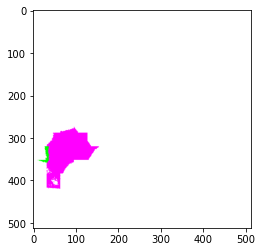

In [73]:
from matplotlib import pyplot as plt
plt.imshow(opimg)
plt.show()

In [79]:
opimg = opimg.astype(np.uint8)
im = Image.fromarray(opimg)
im.save('0001.png')

In [35]:
mask = Image.open('0001.png') # .resize((224, 224))
mask = np.array(mask).astype(np.uint8) # .reshape(224*224, 3)


In [36]:
mask = (mask >= 128).astype(int)

In [37]:
mask = 4 * mask[:, :, 0] + 2 * mask[:, :, 1] + mask[:, :, 2]

In [38]:
np.bincount(mask.flatten())

array([     0,      0,    332,      0,      0,   8902,      0, 252910])

In [42]:
np.pad([1,2,3], (0, 8 - 3), mode='constant')

array([1, 2, 3, 0, 0, 0, 0, 0])

# Contribution
Many thanks to the following implementation.
1. https://github.com/shelhamer/fcn.berkeleyvision.org/
2. https://github.com/wkentaro/pytorch-fcn